In [277]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

from scipy.ndimage import maximum_filter


import sys
import importlib

sys.path.append('..')
import nsgp_vi_covar
from nsgp_vi_covar import nsgpVI

import geopandas as gpd

import pickle

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels


In [265]:
dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")


#Load the data

df = pd.read_csv('../data/wildebeest_data/wildebeest2019a.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]
df = df[df['Temp_8day'].notna()]
#df = df[df.steptime<12]

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')

secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60)
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean


X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

ID = df['ID'].values 



/maths/ctorney/anaconda3/envs/tf2.6/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_4064/1298943501.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
/tmp/ipykernel_4064/1298943501.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


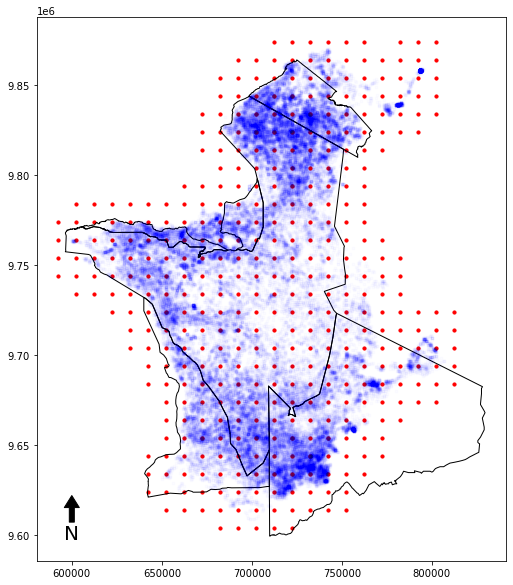

410

In [296]:

# Set up the grid - previous code
offset = 1#50
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=3)


xx = xx[H>1]
yy = yy[H>1]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

num_inducing_points_ = x_grid.shape[0]


np.random.shuffle(x_grid)

#x_grid += np.random.normal(scale=0.1*gridwidth,size=x_grid.shape)
num_inducing_points_

x_grid.shape
plt.figure(figsize=(10,10))
ax = plt.subplot()

dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)
plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
plt.show()

num_inducing_points_

In [267]:
df

,AID,x,y,Date,migrant,SPECIES,COLLAR_ID,OWNER,SEX,year,...,rel.angle,Edge,Village_Dist,Tourism_fpt,Rangerpost_Dist,Temp,NDVI,Temp_8day,Nitrogen,ID
17988,W27,654992.2097,9759749.123,6/9/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,1.109406,0.124279,14153.179690,0.056567,2.906835,22.348169,0.3195,32.83,0.840710,0
17989,W27,648456.1466,9762994.705,6/9/2013 18:00,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.430076,1.003460,14519.379880,0.036662,8.616692,23.249017,0.3244,34.79,0.820383,0
17990,W27,646249.6810,9763062.731,6/10/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,-0.517380,2.102973,14577.379880,0.031140,10.733989,23.328470,0.3302,33.43,0.839792,0
17991,W27,639932.1047,9766920.441,6/10/2013 18:01,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.246703,0.790269,13050.379880,0.018909,6.762931,24.326074,0.2876,34.17,0.834002,0
17992,W27,638311.3819,9767424.449,6/11/2013 6:30,1,WB,T5H-2175,HOPCRAFT,F,2013,...,0.834457,0.719645,13793.110350,0.017756,6.309243,22.310251,0.3051,33.83,0.845218,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234493,W87,689078.2869,9756332.317,6/2/2019 2:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,-0.411165,1.722043,6250.000000,0.026274,3.321243,17.810464,0.3021,32.35,0.682238,41
234494,W87,690375.3396,9756205.652,6/2/2019 6:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,-1.100837,1.722293,6708.204102,0.024597,2.481872,22.890482,0.3656,30.23,0.706873,41
234495,W87,691521.6221,9753273.028,6/2/2019 10:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,-1.122284,4.735965,9953.014648,0.026027,4.974600,27.844232,0.3292,30.51,0.754471,41
234496,W87,690937.0943,9752645.166,6/2/2019 18:30,1,WB,T5H-6663,HOPCRAFT,M,2019,...,-2.499474,5.306270,10446.290040,0.027378,5.660530,21.929941,0.3830,29.65,0.754471,41


In [268]:
# add distance to seronera as excluded from village dist metric
#df['Seronera'] = (((df['x'].values-702639.765)**2+(df['y'].values-9730629.191)**2)**0.5)/1000
#df['Naabi'] = (((df['x'].values-721909.102)**2+(df['y'].values-9686563.760)**2)**0.5)/1000



In [307]:
#predictor = np.min(df['Village_Dist'].values[...,None]/1000,df['Rangerpost_Dist'].values[...,None]/1000)
df['Village_Dist2'] = df['Village_Dist']/1000
#min(df['Village_Dist'],df['Rangerpost_Dist'])

#predictor = df[['Rangerpost_Dist','Rangerpost_Dist']].min(axis=1).values[...,None]
#predictor = df[['Rangerpost_Dist','Village_Dist2','Seronera','Naabi']].min(axis=1).values[...,None]
predictor = df['Village_Dist2'].values[...,None]
predictor.max()

63.94137891

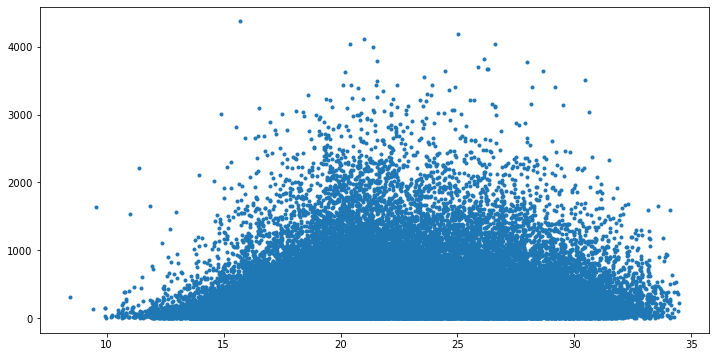

In [252]:
vels = df['dist'].values/df['steptime'].values

temps =  df['Temp'].values
temps = temps[np.isfinite(vels)]
vels = vels[np.isfinite(vels)]

temps = temps[vels<5000]

vels = vels[vels<5000]


#plt.hist(vels)

plt.plot(temps,vels,'.')
plt.show()

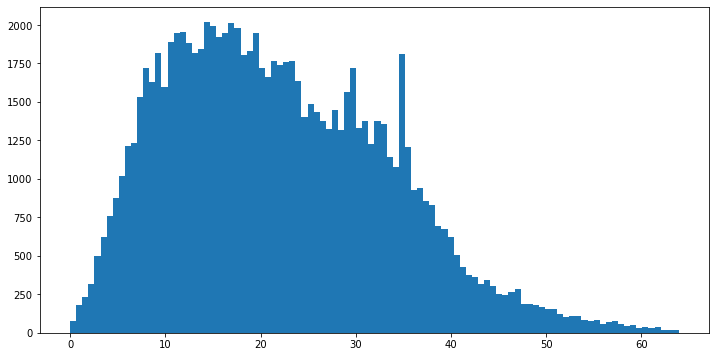

In [309]:
plt.hist(predictor,bins=100)
plt.show()

In [295]:
num_inducing_points_ = 20


Z = np.linspace(predictor.min(), predictor.max(), num_inducing_points_)[...,np.newaxis] 

# # Set up the grid
# offset = 20
# gridwidth = 10 # width in kilometres
# xmin = gridwidth*(((x.min()-offset)//gridwidth))
# xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

# ymin = gridwidth*(((y.min()-offset)//gridwidth))
# ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

# gridx = np.arange(xmin,xmax,gridwidth)
# gridy = np.arange(ymin,ymax,gridwidth)

# H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# xedges = 0.5*(xedges[1:]+xedges[:-1])
# yedges = 0.5*(yedges[1:]+yedges[:-1])

# xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# # only keep if a wildebeest has been in the cell or a neighbouring cell
# H = maximum_filter(H, size=1)

# xx = xx[H>0]
# yy = yy[H>0]


# x_grid = np.array([xx.flatten(), yy.flatten()])
# x_grid = x_grid.T

# x_grid_r = x_grid.copy()
np.random.shuffle(Z)
Z
# print(x_grid.shape)

# x_grid.shape[0]

array([[1.66595697],
       [0.99957242],
       [0.81783118],
       [1.60537656],
       [0.63608994],
       [1.18131367],
       [0.57550953],
       [1.54479615],
       [0.69667036],
       [1.12073325],
       [0.75725077],
       [1.24189408],
       [0.93899201],
       [0.8784116 ],
       [1.36305491],
       [1.42363532],
       [1.06015284],
       [1.48421573],
       [1.30247449],
       [0.51492912]])

In [255]:
# indices = np.random.choice(X.shape[0], 500, replace=False)
# x_grid=X[indices].copy()

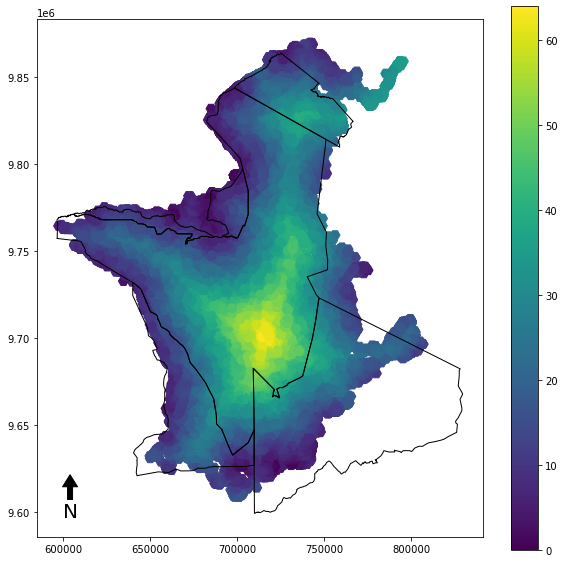

In [308]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


ax.set_aspect('equal')
xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)


#plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=predictor[:,0])
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')

plt.scatter((x+xmean)*1000,(y+ymean)*1000,c=predictor[:,0],cmap='viridis',marker='H',s=100)#vmin,vmax
plt.colorbar()
plt.show()


In [232]:
# create the dataset

BATCH_SIZE=8
SEG_LENGTH=500

allT = []
allX = []
allP = []
for i in np.unique(ID):
    if T[ID == i].shape[0]<SEG_LENGTH:
        continue
    allT.append(T[ID == i])
    allX.append(X[ID == i])
    allP.append(predictor[ID == i])


num_training_points_ = 0
for tt in allT:
    num_training_points_+=(tt.shape[0]//SEG_LENGTH)*SEG_LENGTH
print('..',num_training_points_,'..')

.. 85000 ..


In [233]:

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        #self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 
        P = allP[self.i] 
        
        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]

        PP = P[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        
    
        self.j += 1
        
        if (self.j+1)*SEG_LENGTH > T.shape[0]:
            self.i+=1
            self.j=0

        return TT,XX,PP

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,1]))) 
#dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

In [297]:

class segment_generator:
    def __iter__(self):
        self.i = 0
        self.max_i = len(allT)
        self.j = 0
        self.rand_start = np.random.randint(SEG_LENGTH)
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            raise StopIteration
                
        T = allT[self.i]
        X = allX[self.i] 
        P = allP[self.i] 

        jj = np.arange(self.rand_start+self.j*SEG_LENGTH,self.rand_start+(self.j+1)*SEG_LENGTH)
        
        jj = jj%T.shape[0]

        jj = np.sort(jj)
        TT = T[jj]#np.take(T,jj,mode='wrap',axis=0)#T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[jj]#np.take(X,jj,mode='wrap',axis=0)#X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        PP = P[jj]
        self.j += 1
        if self.j == T.shape[0]//SEG_LENGTH:
        #if self.rand_start+(self.j*SEG_LENGTH) > T.shape[0]:
            #print(self.i,self.j,self.rand_start,T.shape[0])
            self.i+=1
            self.rand_start = np.random.randint(SEG_LENGTH)
            self.j=0
        #else:
            
        return TT,XX,0.5*(PP[:-1]+PP[1:])
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,1]))) 
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
dataset = dataset.with_options(options)


In [298]:
for d in dataset:
    print(d[0].shape,d[1].shape,d[2].shape)
    #break

(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(8, 500, 1) (8, 500, 2) (8, 499, 1)
(2, 500, 1) (2, 500, 2) (2, 499, 1)


In [299]:
# ## set up the kernels and model

# kernel_len_a = tfp.util.TransformedVariable(0.5,tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
# kernel_len_l = tfp.util.TransformedVariable(20.,tfb.Chain([tfb.Shift(np.float64(5.0)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# # amplitude kernel parameters, lower levels
# kernel_amp_a = tfp.util.TransformedVariable(0.5,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
# kernel_amp_l = tfp.util.TransformedVariable(20.,tfb.Chain([tfb.Shift(np.float64(5.0)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

#     #kernels on the second layer
# kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
# kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

# vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=Z,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=5,num_parallel_samples=20,init_observation_noise_variance=1e-3)  

In [310]:
# in case we need to reload
importlib.reload(nsgp_vi_covar)
from nsgp_vi_covar import nsgpVI

In [311]:
kernel_len_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_len_a',trainable=1)
kernel_amp_a = tfp.util.TransformedVariable(1,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=1)

kernel_amp_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(5.05)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=1)
kernel_len_l = tfp.util.TransformedVariable(20.0,tfb.Chain([tfb.Shift(np.float64(5.05)),tfb.Softplus()]), dtype=tf.float64, name='k_len_l',trainable=1)

#kernels on the lower layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

init_observation_noise_variance = 1e-4 # corresponds to a 10m s.d.
untransformed_obs_noise = np.log(np.exp(init_observation_noise_variance)-1) 

obs_noise_prior = tfp.distributions.Normal(loc=np.float64(untransformed_obs_noise),scale=np.float64(0.1))

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,
             inducing_index_points=x_grid,dataset=dataset,num_training_points=num_training_points_, 
             num_sequential_samples=1,num_parallel_samples=20,init_observation_noise_variance=init_observation_noise_variance,
             obs_noise_prior=obs_noise_prior,jitter=1e-6) 


In [315]:
vgp.beta_amp

<tf.Variable 'amp_beta:0' shape=(1,) dtype=float64, numpy=array([-1.19185781])>

In [313]:
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=200)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loss 13509.656054, klen_l 31.920019, kamp_l 22.998474, obs 0.010000: 100%|██████████| 200/200 [29:26<00:00,  8.83s/it]


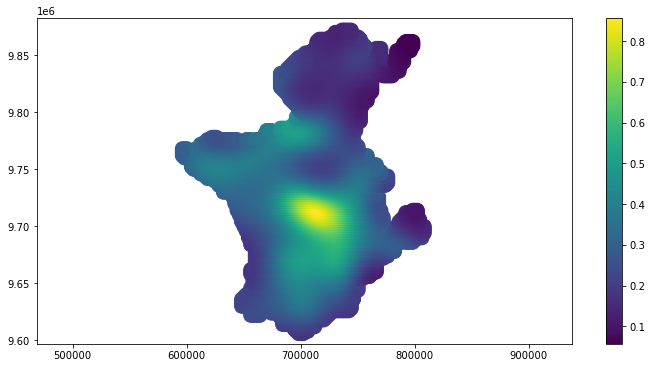

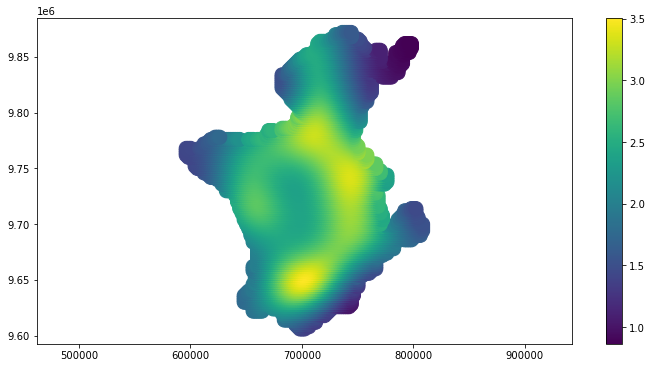

In [316]:

# dense grid for plotting
offset = 10
gridwidth = 2 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)
ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell
H = maximum_filter(H, size=3)

xx = xx[H>0]
yy = yy[H>0]

px_grid = np.array([xx.flatten(), yy.flatten()])
pX_grid=px_grid.T


pmean_list, var_list = vgp.get_marginal(px_grid.T[None])

#mean, var = vgp.get_conditional(px_grid.T)

#pmean_list = tf.split(mean[0],2,axis=0)
        
len_grid = (tf.math.softplus(vgp.mean_len) + tf.math.sigmoid(pmean_list[0])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = (tf.math.softplus(vgp.mean_amp) + tf.math.sigmoid(pmean_list[1])).numpy()#0.0+tf.math.exp(vgp.mean_len+mean_list[0]).numpy() #+ 0.0*var_list[0].numpy()


len_grid = 0.0+tf.math.exp(vgp.mean_len+pmean_list[0]).numpy() #+ 0.0*var_list[0].numpy()
var_grid = 0.0+tf.math.exp(vgp.mean_amp+pmean_list[1]).numpy() #+ 0.0*var_list[0].numpy()

#var_grid = tf.math.exp(vgp.mean_amp+mean_list[1]).numpy()**0.5
plt.scatter((px_grid[0]+xmean)*1000,(px_grid[1]+ymean)*1000,c=(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax
plt.colorbar()

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')

plt.axis('equal')

plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
plt.ylim([1000*(ymin+ymean),1000*(ymax+ymean)])

plt.show()
#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=10,c='r')
#plt.figure(figsize=(20,20))
plt.scatter((px_grid[0]+xmean)*1000+0000,(px_grid[1]+ymean)*1000,c=(len_grid),cmap='viridis',marker='o',s=200)#,vmax=10.,vmin=0.05)#vmin,vmax
plt.colorbar()
plt.axis('equal')



# plt.figure(figsize=(10,10))
# ax = plt.subplot()

# dfpark = gpd.read_file("../data/wildebeest_data/v4_serengeti_ecosystem.shp")

# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
#for wid in np.unique(ID):




    #plt.plot((x+xmean)*1000,(y+ymean)*1000,'.',c='b',alpha=0.01)

        #if wid==31:
#    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.1)#,c='b')
        #else:
        #    plt.plot((x[ID==wid]+xmean)*1000,(y[ID==wid]+ymean)*1000,'.',alpha=0.01,c='r')

#plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,s=1,c='r')
#plt.title(str(wid) + " len: " + str(len(x[ID==wid])))
#plt.show()

#plt.xlim([1000*(xmin+xmean), 1000*(xmax+xmean)])
#plt.ylim([1000*(ymin+xmean),1000*(ymax+xmean)])

plt.show()



In [167]:
# x_grid for plotting

# offset = 0
# gridwidth = 3 # width in kilometres
# xmin = gridwidth*(((x.min()-offset)//gridwidth))
# xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

# ymin = gridwidth*(((y.min()-offset)//gridwidth))
# ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

# gridx = np.arange(xmin,xmax,gridwidth)
# gridy = np.arange(ymin,ymax,gridwidth)

# H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

# xedges = 0.5*(xedges[1:]+xedges[:-1])
# yedges = 0.5*(yedges[1:]+yedges[:-1])

# xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# # only keep if a wildebeest has been in the cell

# H = maximum_filter(H, size=1)

# xx = xx[H>0]
# yy = yy[H>0]

# x_grid = np.array([xx.flatten(), yy.flatten()])
# X_grid=x_grid.T

# X_grid.shape

Z.shape

(20, 1)

In [217]:
Z.max()

1.665956974

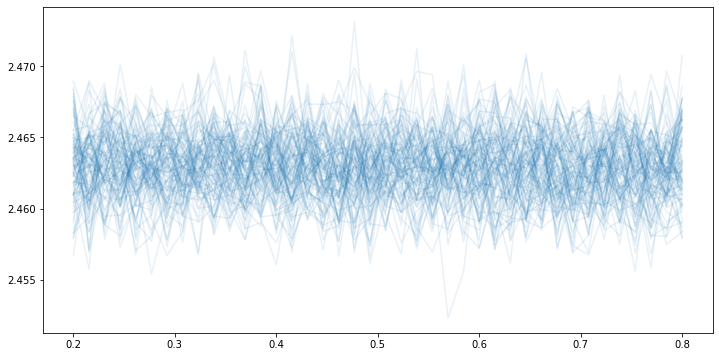

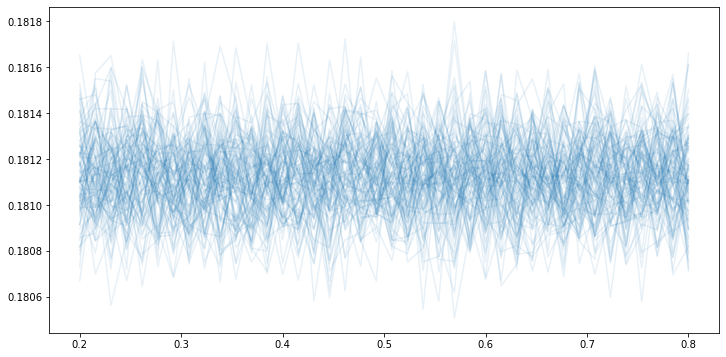

In [262]:
nsamp = 100

Znew = np.linspace(0.2,0.8,2*num_inducing_points_)[None,...,np.newaxis] 

len_s, amp_s = vgp.get_samples(Znew,S=nsamp)

for i in range(nsamp):
    plt.plot(Znew[0,:,0],len_s[i,0,:,0],alpha=0.1,c='C0')

#plt.ylim(0,0.2)
plt.show()

for i in range(nsamp):
    plt.plot(Znew[0,:,0],amp_s[i,0,:,0],alpha=0.1,c='C0')
    
plt.show()

In [185]:
mean_list, var_list = vgp.get_marginal(Znew)


len_grid = (vgp.mean_len+mean_list[0]).numpy() + 0.0*var_list[0].numpy()
var_grid = (vgp.mean_amp+mean_list[1]).numpy()

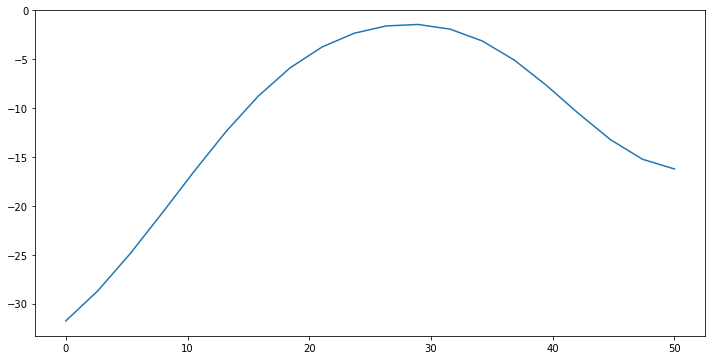

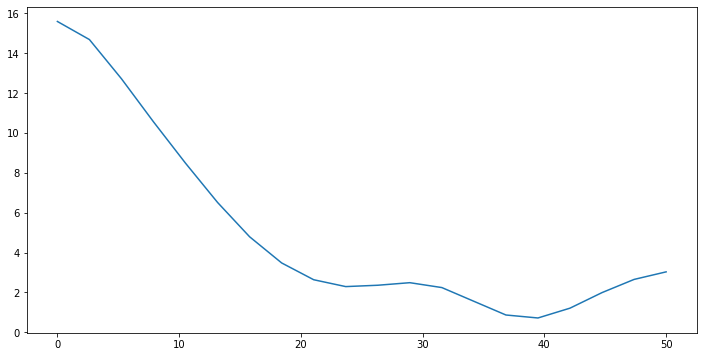

In [186]:
plt.plot(Znew[:,0],len_grid[:,0])
plt.show()
plt.plot(Znew[:,0],var_grid[:,0])
plt.show()

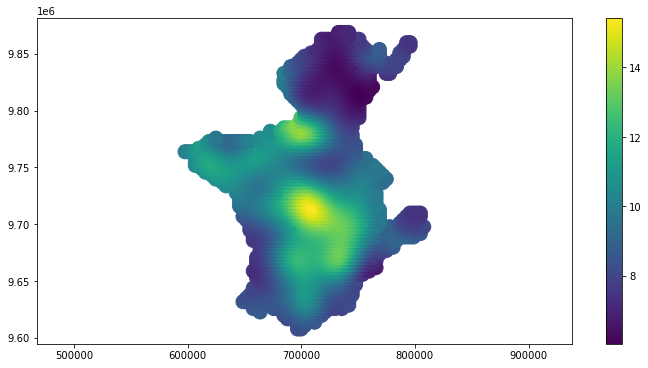

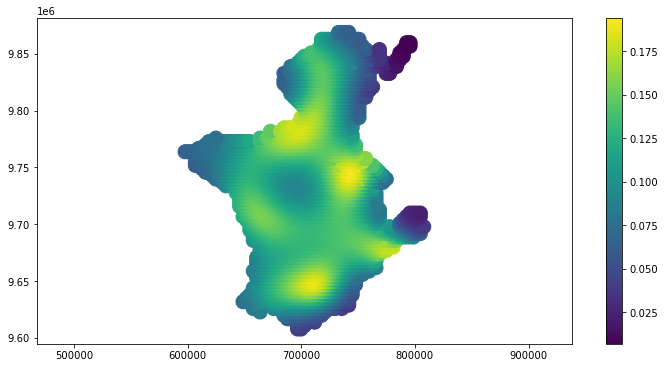

In [16]:
plt.scatter((x_grid[0]+xmean)*1000,(x_grid[1]+ymean)*1000,c=np.exp(var_grid),cmap='viridis',marker='o',s=200)#,vmax=20)#vmin,vmax

#plt.scatter(1000*xmean + 1000*vgp.amp_inducing_index_points.numpy()[:,0],1000*ymean+1000*vgp.amp_inducing_index_points.numpy()[:,1])
plt.axis('equal')
plt.colorbar()
plt.show()

plt.scatter((x_grid[0]+xmean)*1000,(x_grid[1]+ymean)*1000,c=np.exp(len_grid),cmap='viridis',marker='o',s=200)#,vmax=0.16)#vmin,vmax
#plt.scatter(1000*xmean + 1000*vgp.len_inducing_index_points.numpy()[:,0],1000*ymean+1000*vgp.len_inducing_index_points.numpy()[:,1])

plt.axis('equal')
plt.colorbar()
plt.show()

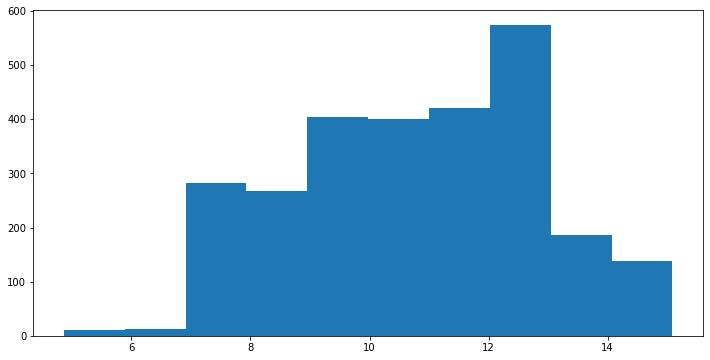

In [47]:
plt.hist(np.exp(var_grid))
plt.show()

In [12]:
vgp.mean_len#.numpy().shape

<tf.Variable 'len_mean:0' shape=(1,) dtype=float64, numpy=array([-2.714713])>

In [163]:
vgp.trainable_variables

(<tf.Variable 'k_amp_a:0' shape=() dtype=float64, numpy=-0.9710715131598405>,
 <tf.Variable 'k_amp_l:0' shape=() dtype=float64, numpy=2.603763203096323>,
 <tf.Variable 'k_len_a:0' shape=() dtype=float64, numpy=0.3732234625181482>,
 <tf.Variable 'k_len_l:0' shape=() dtype=float64, numpy=2.8257930644711804>,
 <tf.Variable 'var_mean:0' shape=(1,) dtype=float64, numpy=array([3.66131576])>,
 <tf.Variable 'len_mean:0' shape=(1,) dtype=float64, numpy=array([-5.2044571])>,
 <tf.Variable 'ind_loc_post:0' shape=(40,) dtype=float64, numpy=
 array([  1.59012218,   1.7032065 ,   2.83345381,   3.18752963,
         -5.54418772,  -5.09641284,   1.44675233,  -6.8486576 ,
          1.38293358,  -7.16233628,  -1.70630133, -12.26570709,
          5.72592126,   2.00460256,  -3.19522468,   2.0049006 ,
         -3.44841935,  -3.91502063,  -1.56840101,  -6.8230548 ,
         -3.11633789,  -3.02200986,  -4.61954021,  -2.21188347,
          6.15267378,   4.99228536,   1.04780517,   6.38835509,
         -2.84728

In [164]:
vgp.amp_inducing_index_points

<tf.Variable 'amp_ind_points:0' shape=(20, 1) dtype=float64, numpy=
array([[40.38402879],
       [57.21070745],
       [10.0960072 ],
       [60.57604318],
       [37.01869305],
       [16.82667866],
       [63.94137891],
       [ 6.73067146],
       [13.46134293],
       [ 3.36533573],
       [33.65335732],
       [ 0.        ],
       [30.28802159],
       [47.11470025],
       [53.84537171],
       [43.74936452],
       [26.92268586],
       [23.55735012],
       [50.48003598],
       [20.19201439]])>

In [19]:

# with open('../data/mcmc/serengeti_data_param_dict.pkl', 'rb') as f:
#     loadp = pickle.load(f)
# m.noise_variance.assign(loadp['noise_variance'])
# m.V_len.assign(loadp['V_len'])
# m.V_len_mean.assign(loadp['V_len_mean'])
# m.k_len_a.assign(loadp['k_len_a'])
# m.k_len_l.assign(loadp['k_len_l'])
# m.V_var.assign(loadp['V_var'])
# m.V_var_mean.assign(loadp['V_var_mean'])
# m.k_var_a.assign(loadp['k_var_a'])
# m.k_var_l.assign(loadp['k_var_l'])

In [20]:
# tf.nn.softplus(0.1)
# #np.log(np.exp()-1)

# x = np.log(1+np.exp(0.1))
# print(x)
# np.log(np.exp(x)-1)
m.V_len.shape

TensorShape([1048])

In [21]:
m.dist_optimize(iters=100)


Loss 283608.597512: 100%|██████████| 100/100 [16:09<00:00,  9.70s/it]


[41.00022718]
[19.19308402]
[-0.63057695]
[0.25299545]
[67.48771943]
[-2.661876]


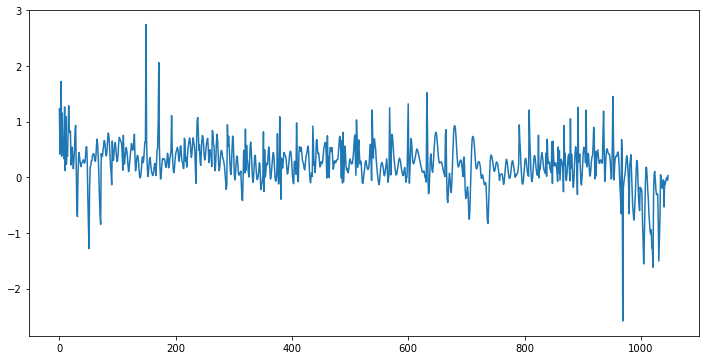

In [22]:
# x_grid
print(np.exp((m.k_len_l).numpy()))
print(np.exp((m.k_var_l).numpy()))

print((m.k_len_a).numpy())
print((m.k_var_a).numpy())
#print(m.gp_prior(m.len_transform(m.V_len),m.var_transform(m.V_var)))
print(1000*tf.math.softplus(m.noise_variance).numpy())

print(m.noise_variance.numpy())
plt.plot(m.V_var.numpy())

[3.72383265]
[3.08062998]
[-0.2680196]
[0.56919463]
[65.25503724]
[-2.6966471]


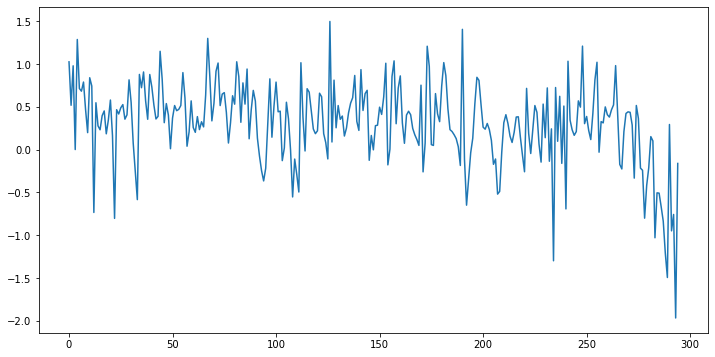

In [10]:

# x_grid
print((m.k_len_l).numpy())
print((m.k_var_l).numpy())

print((m.k_len_a).numpy())
print((m.k_var_a).numpy())

print(1000*tf.math.softplus(m.noise_variance).numpy())

print(m.noise_variance.numpy())
plt.plot(m.V_var.numpy())

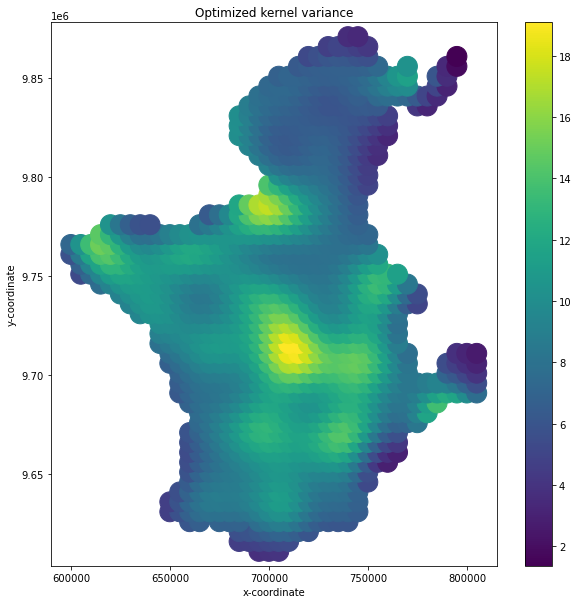

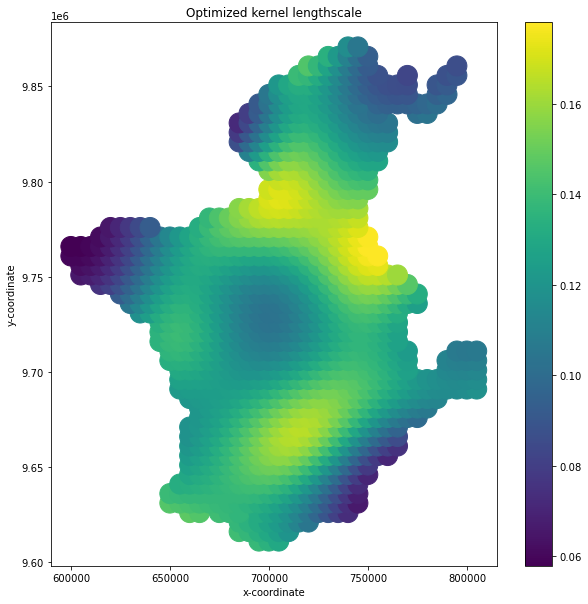

In [24]:
offset = 0
gridwidth = 5 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell


H = maximum_filter(H, size=1)

#A[A !=0] = 1
#A[A ==0] = 0

xx = xx[H>0]
yy = yy[H>0]


# xx = xx[np.abs(yy)<50]
# yy = yy[np.abs(yy)<50]

x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid=x_grid.T

x_grid.shape

len_grid = m.predict_length(Xnew=x_grid).numpy()#.reshape(numy,numx)
var_grid = m.predict_var(Xnew=x_grid).numpy()#.reshape(numy,numx)



plt.figure(figsize=(10,10))
ax = plt.subplot()
# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)


plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=var_grid[:,0]**0.5,cmap='viridis',marker='o',s=400)#,vmax=10)
#plt.show()
#plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10,10))
# ax = plt.subplot()
# dfpark[dfpark.NAME.isin(["Serengeti","Ngorongoro","Masaai Mara Nati","Grumeti","Ikorongo","Maswa"])].boundary.plot(ax=ax,color='black',linewidth=1)#, edgecolor='black')


# ax.set_aspect('equal')
# xarrow, yarrow, arrow_length = 0.075, 0.12, 0.07
# ax.annotate('N', xy=(xarrow, yarrow), xytext=(xarrow, yarrow-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)


plt.scatter((x_grid[:,0]+xmean)*1000,(x_grid[:,1]+ymean)*1000,c=len_grid,cmap='viridis',marker='o',s=400)#,vmax=0.200)
#plt.show()
#plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')

plt.show()

0.011148105992106971


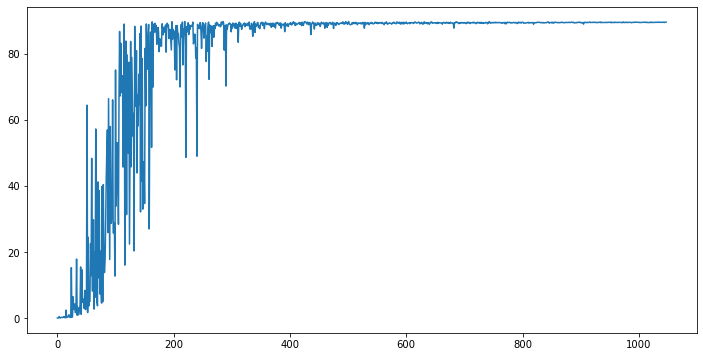

In [41]:
# initial guess at step size based on effect on GP functions
offset = m.X_grid.shape[0]/X.shape[0] # estimate of relative difference between gp prior and data likelihood

print(offset)
with tf.GradientTape() as t:
    kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l))
    K_len = kernel_l.matrix(m.X_grid,m.X_grid)
    L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_len_v = tf.squeeze(tf.linalg.matmul(L_len, tf.expand_dims(m.V_len,-1)))
    f_norm = tf.norm(F_len_v)
grad_len = t.gradient(f_norm,[m.V_len])[0].numpy()
len_step = (offset+np.abs(grad_len))**-1

with tf.GradientTape() as t:
    kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l))
    K_var = kernel_v.matrix(m.X_grid,m.X_grid)
    L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_var_v = tf.squeeze(tf.linalg.matmul(L_var, tf.expand_dims(m.V_var,-1)))
    f_norm = tf.norm(F_var_v)
grad_var = t.gradient(f_norm,[m.V_var])[0].numpy()
var_step = (offset+np.abs(grad_var))**-1


plt.plot(var_step)
plt.show()

In [4]:
print(tfp.__version__)
print(tf.__version__)

0.13.0-rc0
2.5.0


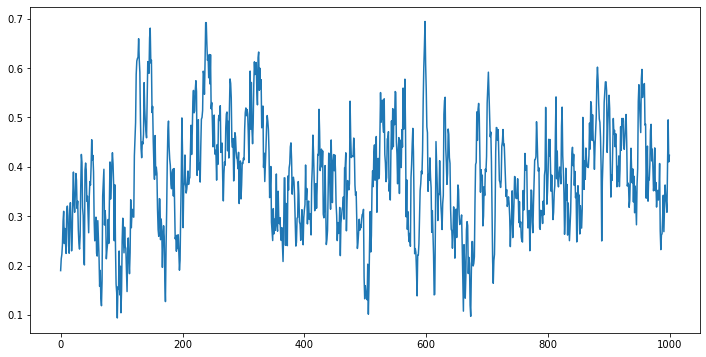

279

In [5]:

aa = np.load('../data/mcmc/serengeti_data_1_0.npy')
aa.shape

plt.plot(aa[:,278])
plt.show()

esses = tfp.mcmc.effective_sample_size(aa[::10]).numpy().reshape((-1))
esses.argmin()

In [6]:

df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]


print(len(df))
#df = df[df.steptime<12]
print(len(df))

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')




/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


94007
94007


In [7]:



#Load the data

df = pd.read_csv('../data/wildebeest_data/wildebeest2019.csv')
# Select all the rows where the OWNER is HOPCRAFT
df = df[df['OWNER'] == 'HOPCRAFT']
#Select all the rows where the species is WB
df = df[df['SPECIES'] == 'WB']
#Select all the rows where the animal is a migrant
df = df[df['migrant'] == 1]
# only use values post 2013 (higher accuracy, more fixes, accurate resident indicator)
df = df[pd.to_datetime(df['Date']).dt.year>=2013]


#df = df[df.steptime<12]

df['ID'] = df['AID'].astype('category').cat.rename_categories(range(0, df['AID'].nunique())).astype('int')

secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24)
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

print(np.shape(X))
print(np.shape(T))

/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(94007, 2)
(94007, 1)


<ipython-input-7-f4fbfcdedfe6>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
<ipython-input-7-f4fbfcdedfe6>:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [8]:
# Set up the grid
offset = 0
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>0]
yy = yy[H>0]


x_grid = np.array([xx.flatten(), yy.flatten()])
x_grid = x_grid.T

x_grid_r = x_grid.copy()
np.random.shuffle(x_grid_r)
print(x_grid_r.shape)

m = GPMove(T,x_grid_r,X,ID,BATCH_SIZE=1000,k_len_l=10.0, k_var_l=10.0)

(295, 2)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [9]:
m.dist_optimize(iters=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


Loss 254834.322910: 100%|██████████| 1000/1000 [33:08<00:00,  1.99s/it]


0.0031380641867095


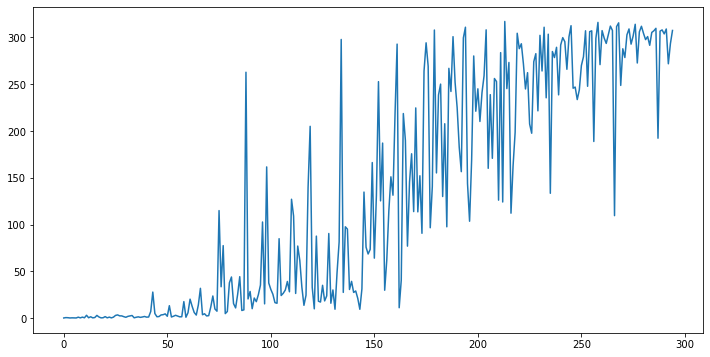

In [18]:


num_warmup = 3
warmup_steps = 10#200
n_samples = 10#500
num_leapfrog_steps=10
step_size=[np.float64(0.1)*len_step,np.float64(0.1)*var_step]

n_chains=10
init_value = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
                                           


In [19]:

kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)


kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)

pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps + n_samples - 1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples= tfp.mcmc.sample_chain(num_results=n_samples, num_burnin_steps=warmup_steps,
                                current_state=init_value, kernel=kernel, trace_fn=None)

100%|██████████| 19/19 [40:29<00:00, 127.87s/it] 


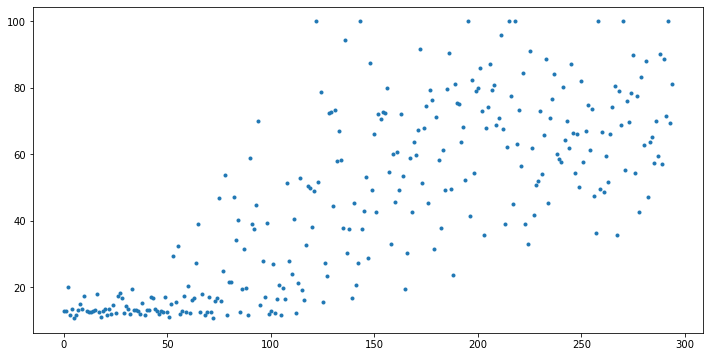

In [20]:
esses2 = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)) for ss in samples]
plt.plot(esses2[0],'.')
#plt.plot(esses[0],'.')

plt.show()
#plt.plot(esses[0],esses2[0],'.')
#plt.show()

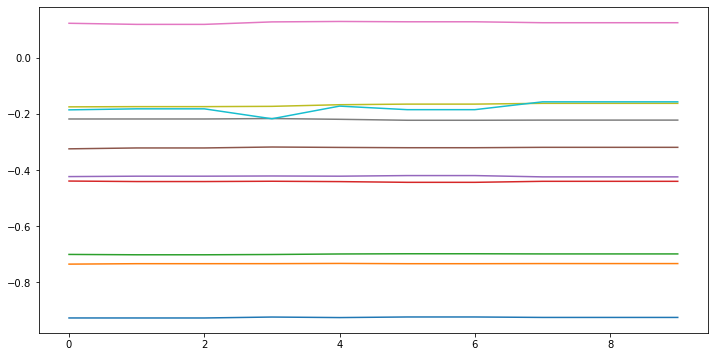

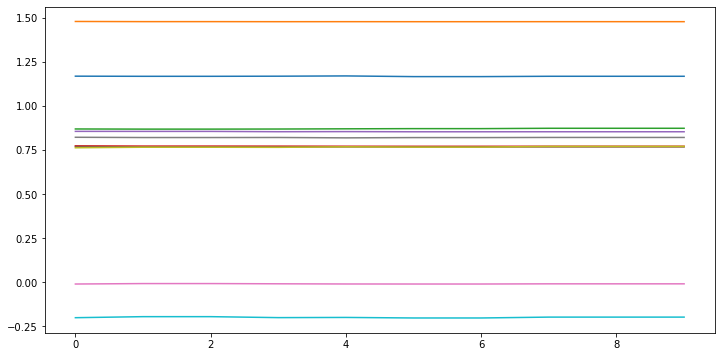

In [23]:
j=2

for ss in samples:
    plt.plot(ss[:,j,:10])
    plt.show()

In [6]:
# for aa in pd.unique(df.AID):
#     xcheck = df[df.AID==aa].x.values/1000
#     ycheck = df[df.AID==aa].y.values/1000
#     print(aa,xcheck.shape[0])

In [7]:
# # plt.hist(df.dist,bins=100)
# # plt.show()
# # df.dist.argmax()
# # df.iloc[15579]
# check = 'W51'
# xcheck = df[df.AID==check].x.values/1000
# ycheck = df[df.AID==check].y.values/1000
# tcheck = pd.to_datetime(df[df.AID==check].Date)
# xcheck =xcheck - xmean
# ycheck = ycheck - ymean

# plt.plot(tcheck,xcheck,'o')
# plt.plot(tcheck,ycheck,'o')
# #plt.axis('equal')
# plt.show()

In [8]:
secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24)
T = T[:,None]
x = df.x.values/1000
y = df.y.values/1000
xmean =  x.mean()
ymean = y.mean()
x = x - xmean
y = y - ymean

ID = df['ID'].values 

X = np.zeros((len(x),2))
X[:,0] = x
X[:,1] = y

<ipython-input-8-a9fe4b12ceb9>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  secs =(pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.seconds.astype(float).values
<ipython-input-8-a9fe4b12ceb9>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (pd.to_datetime(df['Date'])- pd.datetime(2013,1,1)).dt.days.astype(float).values


In [9]:
# plt.hist(df.steptime,range=(0,10),bins=100)
# plt.show()

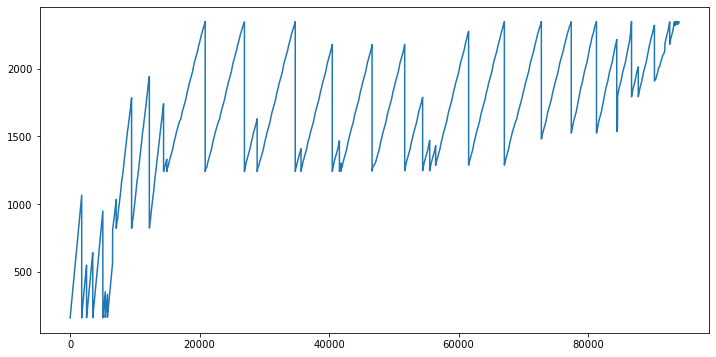

In [10]:
plt.plot(T)

In [13]:

offset = 10
gridwidth = 10 # width in kilometres
xmin = gridwidth*(((x.min()-offset)//gridwidth))
xmax = gridwidth*(((x.max()+offset)//gridwidth)+2)

ymin = gridwidth*(((y.min()-offset)//gridwidth))
ymax = gridwidth*(((y.max()+offset)//gridwidth)+2)

gridx = np.arange(xmin,xmax,gridwidth)
gridy = np.arange(ymin,ymax,gridwidth)

H, yedges, xedges = np.histogram2d(y, x,bins=[gridy,gridx])

xedges = 0.5*(xedges[1:]+xedges[:-1])
yedges = 0.5*(yedges[1:]+yedges[:-1])

xx, yy = np.meshgrid(xedges, yedges, sparse=False)

# only keep if a wildebeest has been in the cell or a neighbouring cell
H = maximum_filter(H, size=1)


xx = xx[H>0]
yy = yy[H>0]


x_grid = np.array([xx.flatten(), yy.flatten()])
X_grid=x_grid.T

x_grid.shape


(2, 295)

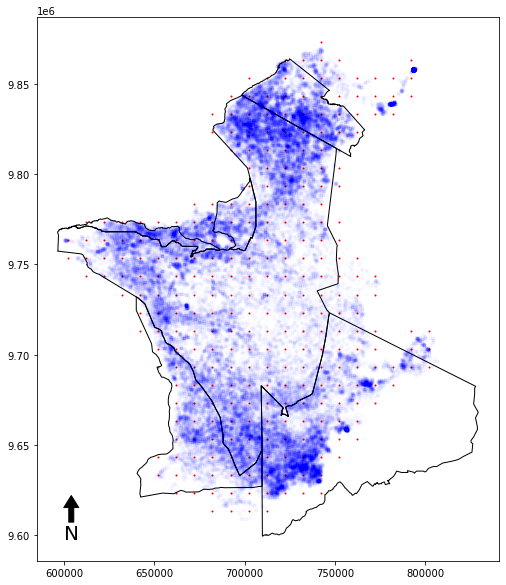

In [69]:
# # Set up the grid
# num=int(20)


# x1=y1 = np.array(np.linspace(-10,-5,int(num/2)))
# x2=y2 = np.array(np.linspace(5,10,int(num/2)))

# x = y = np.array(np.linspace(-5, 5, num))

# x = np.concatenate([x1,x])
# x = np.concatenate([x,x2])

# y = np.concatenate([y1,y])
# y = np.concatenate([y,y2])[...,np.newaxis]


# Unew = np.zeros((2*num,2))
# Unew[:,0] = np.squeeze(x)
# Unew[:,1] = np.squeeze(y)
# xx, yy = np.meshgrid(x, y, sparse=False)
# x_grid = np.array([xx.flatten(), yy.flatten()])
# X_grid=x_grid.T
# print(np.shape(X_grid))

In [70]:
# df = pd.read_csv('Real_data.csv')
# T = (df['Time'].values[:,None])
# ID = df['ID'].values

# X_x = df['Latitude'].values
# X_y = df['Longitude'].values
# X = np.zeros((len(X_x),2))
# X[:,0] = X_x
# X[:,1] = X_y


In [71]:
# #standardize T 
# T = (T-np.mean(T))/np.std(T)

In [72]:
print(np.shape(X))
print(np.shape(T))
n = np.shape(X)[0]
#all the sizes match

(94007, 2)
(94007, 1)


In [73]:
m = GPMove(T,X_grid,X,ID,BATCH_SIZE=1000,min_kl=np.float64(gridwidth), init_k_len_l=10.0, init_k_var_l=10.0)

In [74]:
# # m.K

# initial_chain_states= m.trainable_parameters

In [75]:


# # Initialize the HMC transition kernel.
# num_results = int(5)
# t0 = time.time()
# samples, kernel_results = tfp.mcmc.sample_chain(
#     num_results=num_results,
#     num_burnin_steps=5,
#     current_state=initial_chain_states,
#     kernel= tfp.mcmc.HamiltonianMonteCarlo(
#             target_log_prob_fn=m.likelihood_fn,
#             step_size=[np.float64(1e-1)],
#             num_leapfrog_steps=8),trace_fn=lambda current_state,kernel_results: kernel_results)
# t1 = time.time()
# print("Inference ran in {:.2f}s.".format(t1-t0))



In [76]:
print(np.shape(m.T))
print(np.shape(m.X))
#138,500 obs in total, 277 batches each having 500 points

(75, 1000, 1)
(75, 1000, 2)


In [77]:
# for i in range(277):
#     thisX = m.X[i]
    
#     thisX = thisX[1:]-thisX[0]
#     thisX = thisX.numpy()
#     thisT = m.T[i]
#     thisT = thisT[1:]-thisT[0]
#     thisT = thisT.numpy()
#     thisX = np.diff(thisX,axis=0)/np.diff(thisT,axis=0)
#     #print(thisT.max())
#     plt.plot(thisT[1:],thisX[:,0])
# plt.show()
    

In [78]:
learning_rate = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=50,
    decay_rate=0.99,
    staircase=True)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,beta_2=0.99)
train_steps = 1000
pbar = tqdm(range(train_steps))
loss_history = np.zeros((train_steps))

for i in pbar:
    with tf.GradientTape() as t:
        loss = -m.likelihood_fn(*m.trainable_parameters)
    loss_history[i] = loss.numpy()
    
    #lenll = (m.min_kl+tf.nn.softplus(m.k_len).numpy())

    pbar.set_description("Loss %f" % loss_history[i])

    gradients = t.gradient(loss, m.trainable_parameters)
    optimizer.apply_gradients(zip(gradients, m.trainable_parameters))

Loss 254244.916779: 100%|██████████| 1000/1000 [21:41<00:00,  1.30s/it]


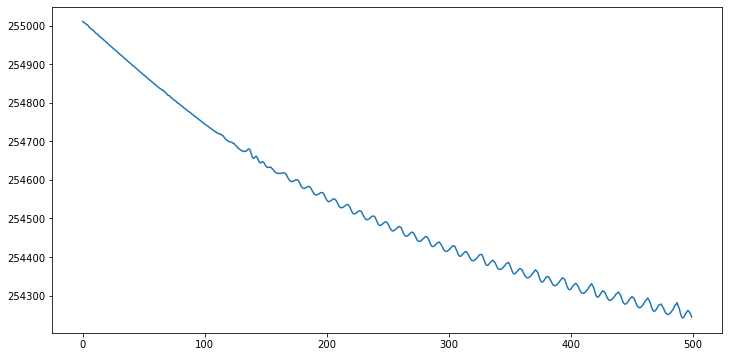

In [79]:
plt.plot(loss_history[500:])
plt.show()

[34.32089304]
[32.76339362]
[1.77829641]
[13.24999068]
[79.75678174]
[-2.48863008]


In [81]:


# xx = np.arange(-150,150,gridwidth)
# yy = np.arange(-150,150,gridwidth)

# numx = xx.shape[0]
# numy = yy.shape[0]
# xx, yy = np.meshgrid(xx, yy, sparse=False)
# x_grid = np.array([xx.flatten(), yy.flatten()],dtype=np.float64)
# x_grid=x_grid.T

(2, 17748)

In [12]:
var_grid.shape
x_grid.shape

(295, 2)

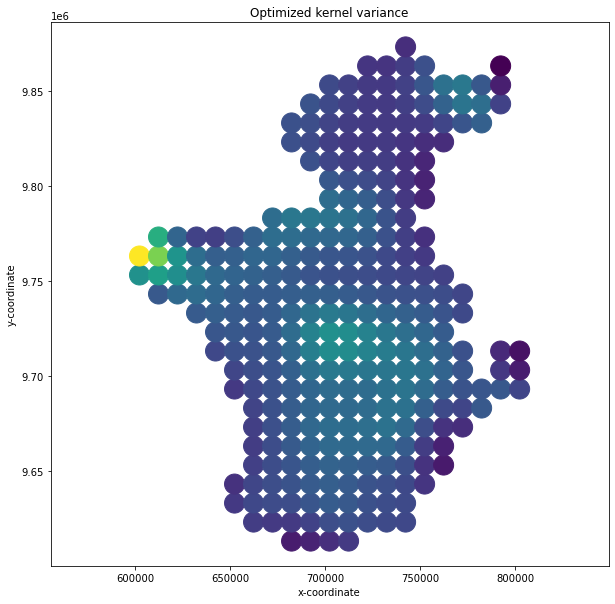

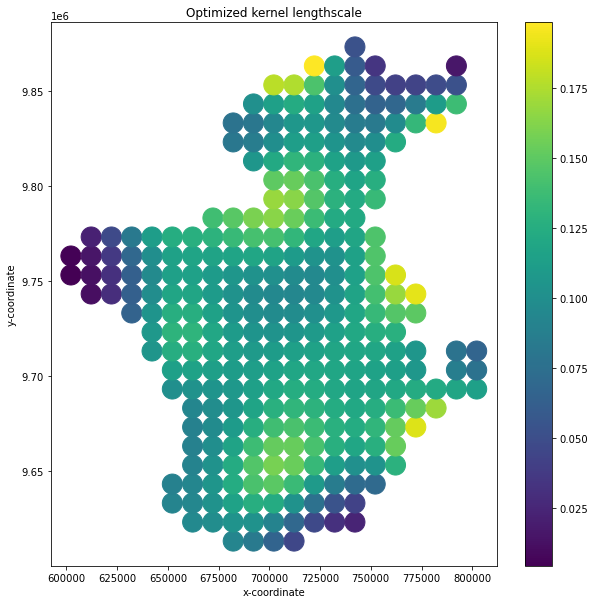

In [30]:
# #plt.contourf(xx,yy,len_grid,levels=200,vmax=1)
# plt.scatter(x_grid[0],x_grid[1],c=len_grid,cmap='viridis',marker='o',s=200)#,vmax=0.50)

# #plt.plot(X[:,0],X[:,1],'.',markersize=1)
# #
# print(xmean)
# ser_x = (702195.29/1000-xmean)
# ser_y = (9729317.33/1000-ymean)

# gate_x = (722118.74/1000-xmean)

# gate_y = (9686765.47/1000-ymean)


# rob_x = (686920.56/1000-xmean)

# rob_y = (9761581.10/1000-ymean)

# #687519.40, 9827726.60
# 709597.35
# 9827454.87
# mara_x = (709597.40/1000-xmean)

# mara_y = (9827454.60/1000-ymean)
# plt.plot(ser_x,ser_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(gate_x,gate_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(rob_x,rob_y,'*',c='r',markersize=10,alpha=0.5)
# plt.plot(mara_x,mara_y,'*',c='r',markersize=10,alpha=0.5)
# plt.colorbar()

# plt.axis('equal')

# plt.xlabel('x-coordinate')
# plt.ylabel('y-coordinate')
# plt.title('Optimized kernel lengthscale')
# plt.show()